In [23]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import sys
import pickle
import blip_analysis as ba
import exp_blip_models as em
from scipy.cluster.hierarchy import dendrogram, linkage
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe
from scipy.stats import ttest_ind
import importlib
importlib.reload(em)
importlib.reload(ba)

b


<module 'blip_analysis' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/blip_analysis.py'>

In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [3]:
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

In [4]:
dasked = daskify.Daskified()
dasked.start_cluster()


In [5]:
client = dasked.client

In [24]:
def dask_fit_split(model_name, model_index):
    importlib.reload(em)
    models = pickle.Unpickler(open(model_name, 'rb')).load()
    model = models[model_index]
    model.fit_split(train_test_var=True)
    return model

In [7]:
full_models1 = np.array(pickle.Unpickler(open('221209_full_models1.pkl', 'rb')).load())[good_indexes]
full_models2 = np.array(pickle.Unpickler(open('221209_full_models2.pkl', 'rb')).load())[good_indexes]
full_models3 = np.array(pickle.Unpickler(open('221209_full_models3.pkl', 'rb')).load())[good_indexes]

cao_models1 = np.array(pickle.Unpickler(open('221209_cao_models1.pkl', 'rb')).load())[good_indexes]
cao_models2 = np.array(pickle.Unpickler(open('221209_cao_models2.pkl', 'rb')).load())[good_indexes]
cao_models3 = np.array(pickle.Unpickler(open('221209_cao_models3.pkl', 'rb')).load())[good_indexes]

conc_models1 = np.array(pickle.Unpickler(open('221209_conc_models1.pkl', 'rb')).load())[good_indexes]
conc_models2 = np.array(pickle.Unpickler(open('221209_conc_models2.pkl', 'rb')).load())[good_indexes]
conc_models3 = np.array(pickle.Unpickler(open('221209_conc_models3.pkl', 'rb')).load())[good_indexes]

onset_models1 = np.array(pickle.Unpickler(open('221209_onset_models1.pkl', 'rb')).load())[good_indexes]
onset_models2 = np.array(pickle.Unpickler(open('221209_onset_models2.pkl', 'rb')).load())[good_indexes]
onset_models3 = np.array(pickle.Unpickler(open('221209_onset_models3.pkl', 'rb')).load())[good_indexes]

In [25]:
dask_futures1 = [dask.delayed(dask_fit_split)('221209_full_models1.pkl', ui) for ui in good_indexes]
dask_futures2 = [dask.delayed(dask_fit_split)('221209_full_models2.pkl', ui) for ui in good_indexes]
dask_futures3 = [dask.delayed(dask_fit_split)('221209_full_models3.pkl', ui) for ui in good_indexes]
dask_futures = dask_futures1 + dask_futures2 + dask_futures3


In [26]:
dask_outs = client.compute(dask_futures)

In [39]:
dasked.current_futures = dask_outs
dasked.check_progress()

finished 390


In [105]:
importlib.reload(em)

model = em.ExponentialCustomTrialArray(unit_usrt1,good_indexes[5], em.trial_arrays['diff_array'])
model.fit_split(train_test_var=True)


b


In [106]:
print(model.test_scores.mean())

1.7924747757394703


In [78]:
print(np.mean((model.pred_test_avg.mean(axis=0)-model.X_test_avg.mean(axis=0))**2))

4.030715505510457


In [85]:
print(np.std(np.mean(model.X_test_avg) - model.X_test_avg.mean(axis=0))**2)
print(np.mean((model.pred_test_avg.mean(axis=0) - model.X_test_avg.mean(axis=0))**2))

7.242205221724835
4.030715505510457


In [75]:
print(full_models1[20].test_scores.mean())

0.08797888759611602


In [76]:
print(np.mean((model.pred_test_avg.mean(axis=0) - model.X_test_avg.mean(axis=0))**2)/model.X_test_avg.mean(axis=0).std()**2)


0.5565591393929713
2.6911345603155623


In [40]:
res = [i.result() for i in dask_outs]

In [41]:
res = np.array(res).reshape(3, 130)

In [61]:
init_scores1 = []
new_scores1 = []
init_scores2 = []
new_scores2 = []
init_scores3 = []
new_scores3 = []
for i in trange(130):
    model = full_models1[i]
    init_scores1.append(model.test_scores.mean())
    new_scores1.append(res[0][i].test_scores.mean())
    model = full_models2[i]
    init_scores2.append(model.test_scores.mean())
    new_scores2.append(res[1][i].test_scores.mean())
    model = full_models3[i]
    init_scores3.append(model.test_scores.mean())
    new_scores3.append(res[2][i].test_scores.mean())


100%|██████████| 130/130 [00:00<00:00, 8278.94it/s]


In [31]:
model = full_models1[0]
print(model.train_scores.mean())
print(init_scores1[0])
print(model.unit_sr_var.mean())
print(model.X_test_avg.mean(axis=0))

0.16081730003878034
0.2744463202583257
20.50206611570248
[13.75533333 16.432      10.88266667 11.85933333 15.864      13.40733333
 13.93133333 12.794      14.81333333 13.35666667 12.96266667 13.442
 13.014      14.11666667 13.422      13.79866667 12.818      11.74466667
 10.10666753 13.00933333 10.62733333 13.68866667 11.158      13.01466667
 12.92133333 13.706      12.23533333 10.93733333 10.092       9.638
 13.23266667 12.264     ]


In [62]:
print(np.mean(new_scores1), np.mean(init_scores1))
print(np.mean(new_scores2), np.mean(init_scores2))
print(np.mean(new_scores3), np.mean(init_scores3))
print(ttest_ind(new_scores1, init_scores1))
print(ttest_ind(new_scores2, init_scores2))
print(ttest_ind(new_scores3, init_scores3))

0.7166382523346293 0.2230192464112078
0.6744445312612916 0.25066582036277457
0.8112882779673004 0.23406819116136493
Ttest_indResult(statistic=11.465114692939688, pvalue=7.230582988980544e-25)
Ttest_indResult(statistic=9.281387610707723, pvalue=7.096266396442375e-18)
Ttest_indResult(statistic=13.74308811731934, pvalue=1.275620807312137e-32)


Text(0, 0.5, 'Normalised fit error')

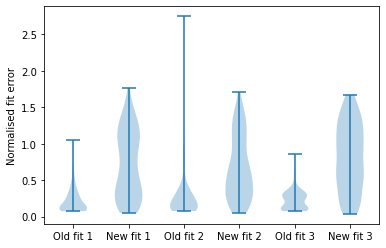

In [63]:
plt.violinplot([init_scores1, new_scores1, init_scores2, new_scores2, init_scores3, new_scores3])
plt.xticks(range(1, 7), labels=['Old fit 1', 'New fit 1', 'Old fit 2', 'New fit 2', 'Old fit 3', 'New fit 3']);
plt.ylabel('Normalised fit error')

5
1.7666662479527822


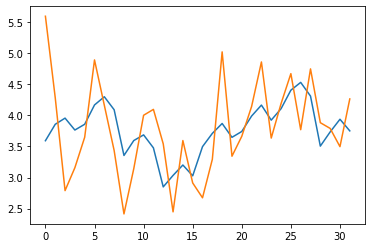

In [68]:
print(np.argmax(new_scores1))
plt.plot(res[0, 5].pred_test_avg.mean(axis=0))
plt.plot(res[0, 5].X_test_avg.mean(axis=0))
print(np.max(new_scores1))

array([1.72505783, 1.53051317, 1.17702231, 1.06719152, 1.08596427,
       0.96790144, 0.85253838, 1.10160213, 1.21274872, 1.41317433,
       1.34144161, 1.3548464 , 0.87816041, 1.66189528, 1.08109386,
       0.94350787, 0.96897749, 1.15467747, 1.02478366, 1.77925719,
       1.42204186, 1.09859029, 1.13959981, 0.6796521 , 1.20610193,
       0.99026893, 1.3464405 , 0.99493124, 1.25798801, 1.03267725,
       1.97840357, 1.30326211, 1.0092742 , 1.18735834, 1.06708137,
       1.12330907, 0.96587988, 1.27339538, 1.2125663 , 1.29349797,
       0.991533  , 1.2152136 , 1.2852195 , 1.15166434, 0.90240419,
       1.17744412, 1.23044569, 1.25083897, 1.01999408, 1.47535623,
       0.9853614 , 1.02082058, 1.10923412, 1.1225858 , 1.65959978,
       1.21139908, 1.55224956, 1.00970132, 1.49853051, 1.3361184 ,
       1.12976126, 0.81270702, 0.78739334, 1.06181427, 1.56509066,
       1.15558224, 0.90198221, 1.17314041, 0.962786  , 1.20690761,
       1.26907858, 0.91353947, 0.82886225, 1.33838338, 1.05044

5
1.7181164143712655
(array([3]),)
0.8966097412237478
0.19508843270887227


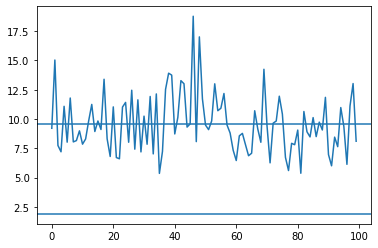

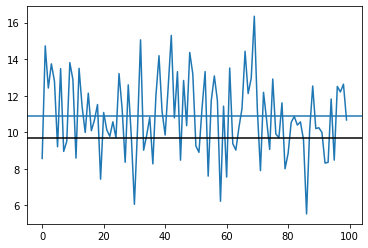

In [52]:
print(np.argmax(new_scores1))
print(np.max(new_scores1))
print(np.where(new_scores1 == np.quantile(new_scores1, 0.5, interpolation='nearest')))
scores_test = []
var_test = []
unnormed_scores = []
for i in range(100):
    scores_test.append(np.mean((new_model.X_test_avg[i] - new_model.pred_test_avg[i])**2)/(np.std(new_model.pred_test_avg[i])**2))
    var_test.append(np.std(new_model.pred_test_avg[i])**2)
    unnormed_scores.append(np.mean((new_model.X_test_avg[i] - new_model.pred_test_avg[i])**2))
print(np.mean(scores_test))
print(np.mean((new_model.X_test_avg.mean(axis=0) - new_model.pred_test_avg.mean(axis=0))**2)/(np.std(new_model.pred_test_avg.mean(axis=0))**2))
plt.plot(unnormed_scores)
plt.axhline(np.mean(unnormed_scores))
plt.axhline(np.mean((new_model.X_test_avg.mean(axis=0) - new_model.pred_test_avg.mean(axis=0))**2))
plt.figure()
plt.axhline(np.mean(var_test))
plt.plot(var_test)
plt.axhline((np.std(new_model.pred_test_avg.mean(axis=0))**2), color='k')

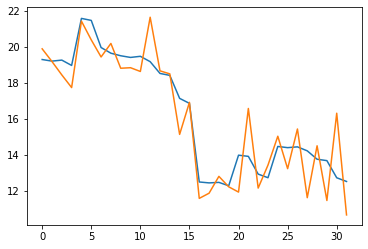

In [42]:
new_model = res[0][3]
plt.plot(new_model.pred_test_avg.mean(axis=0))
plt.plot(new_model.X_test_avg.mean(axis=0))


In [45]:
new_model = res[0][2]
print(new_model.test_scores.mean())
print(full_models1[2].test_scores.mean())

1.2762462486814414
0.26706508056287936


In [24]:
print(np.mean(init_scores1), np.mean(new_scores1))
print(ttest_ind(init_scores1, new_scores1))

0.2230192464112078 0.7147058708255656
Ttest_indResult(statistic=-11.427351851435121, pvalue=9.651635300063004e-25)


0.9


In [49]:
full_joint_models = np.concatenate([full_models1, full_models2, full_models3])

In [50]:
test_preds = np.array([np.mean(i.pred_test_avg, axis=0) for i in full_joint_models])
test_true = np.array([np.mean(i.X_test_avg, axis=0) for i in full_joint_models])
all_test_preds = np.array([i.pred_test_avg for i in full_joint_models])
all_test_true = np.array([i.X_test_avg for i in full_joint_models])
all_scores = np.array([np.mean(i.test_scores) for i in full_joint_models])
scores1 = np.array([np.mean(i.test_scores) for i in full_models1])
scores2 = np.array([np.mean(i.test_scores) for i in full_models2])
scores3 = np.array([np.mean(i.test_scores) for i in full_models3])
print(all_scores.shape)

(390,)


In [56]:
model = res[0][0]
model.avg_testing_scores

0.5154492489044615

In [18]:
print(np.argmin(all_scores))

67


In [52]:
def plot_error_distributions(ax, errors, log=True, yticklabels=None, axvlines=None):
    if log:
        ax.violinplot([np.log10(i) for i in errors], vert=False)
        ax.set_xlabel('Log(Fit error)')
    else:
        ax.violinplot(errors, vert=False)
        ax.set_xlabel('Fit error')
    ax.set_yticks(np.arange(1, len(errors)+1))
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)
    if axvlines is not None:
        for axvline in axvlines:
            ax.axvline(axvline, linestyle='--', color='k')

In [ ]:
print(np.)

In [53]:
worse_fit = np.where(all_scores == np.max(all_scores))[0][0]
percentile25 = np.where(all_scores == np.percentile(all_scores, 25, interpolation='nearest'))[0][0]
median = np.where(all_scores == np.percentile(all_scores, 50,interpolation='nearest'))[0][0]
percentile75 = np.where(all_scores == np.percentile(all_scores, 75, interpolation='nearest'))[0][0]
best_fit = np.where(all_scores == np.min(all_scores))[0][0]
best_fit = np.argsort(all_scores)[0]
fit_indexes = [best_fit, percentile25, median, percentile75, worse_fit]
fit_index_values = [np.log10(all_scores[i]) for i in fit_indexes]

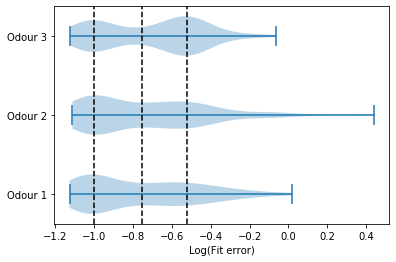

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_error_distributions(ax, combined_scores, yticklabels=['Odour 1', 'Odour 2', 'Odour 3'], axvlines=fit_index_values[1:-1])

In [55]:
def plot_fits(fig, gs, true_vals, pred_vals, chosen_indexes, hor=True, legend_ax_index=2):
    if hor:
        subgs = gs.subgridspec(ncols=len(chosen_indexes), nrows=1)
    else:
        subgs = gs.subgridspec(ncols=1, nrows=len(chosen_indexes))
    axs = []
    for ax_i, index in enumerate(chosen_indexes):
        if ax_i != 0:
            
            ax = fig.add_subplot(subgs[ax_i], sharey=axs[-1])
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax = fig.add_subplot(subgs[ax_i])
            ax.set_ylabel('Firing rate (Hz)')
        ax = plot_fit(ax, true_vals[index], label='True')
        ax = plot_fit(ax, pred_vals[index], label='Prediction')
        axs.append(ax)
        ax.set_xticks(range(32))
        ax.set_xticklabels(glyphs, fontsize=8, rotation=90)
        if ax_i == legend_ax_index:
            ax.legend()
    
    return axs

def plot_fit(ax, vals, label=None):
    mins = np.mean(vals, axis=0) - np.min(vals, axis=0)
    maxs = np.max(vals, axis=0) - np.mean(vals, axis=0)
    
    ax.errorbar(range(32), np.mean(vals, axis=0), yerr=(mins, maxs), fmt='o', label=label, markersize=3, linewidth=1)
    return ax

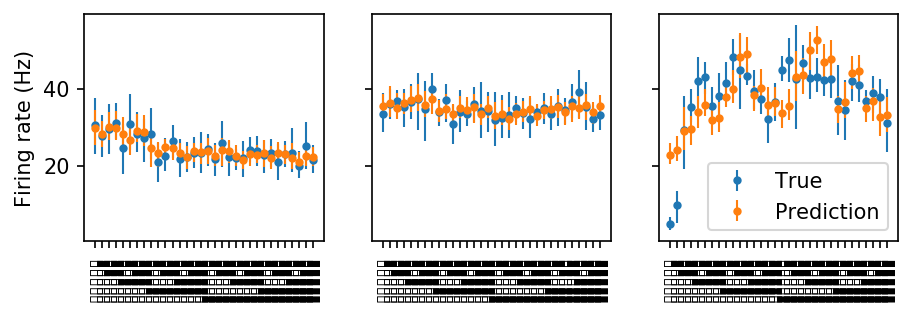

In [56]:
fig = plt.figure(figsize=(7, 2), dpi=150)
gs = GridSpec(1, 1)
plot_fits(fig, gs[0], all_test_true, all_test_preds, fit_indexes[2:])

In [51]:
print(np.max(all_scores))

2.7490870539491525


In [16]:
combined_trial_scores = np.concatenate([[np.mean(i.test_scores, axis=0) for i in models] for models in [full_models1, full_models2, full_models3]])

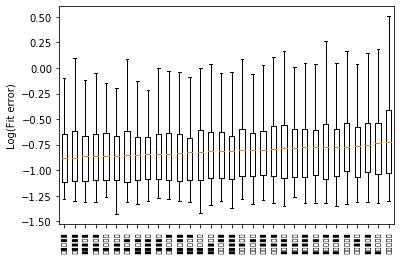

In [33]:
def plot_trial_scores(ax, trial_scores, sort_by_median=True):
    if sort_by_median:
        sorted_index = np.argsort(np.median(np.log10(trial_scores), axis=0))
        sorted_scores = np.log10(trial_scores)[:, sorted_index]
    else:
        sorted_scores = np.log10(trial_scores)
        sorted_index = range(32)
    ax.boxplot(sorted_scores, showfliers=False)
    ax.set_xticks(range(1, 33))
    ax.set_xticklabels(np.array(glyphs)[sorted_index], rotation=90, fontsize=8)
    ax.set_ylabel('Log(Fit error)')
fig = plt.figure()
ax = fig.add_subplot(111)
plot_trial_scores(ax, combined_trial_scores, sort_by_median=True)

#Change to a conc vs onset scatter plot

In [18]:
all_reses = np.load('../Fig2/221027_all_svm_outs.npy')
preds1 = np.array(all_reses)[0, :, 0].reshape(500, 32)
trues1 = np.array(all_reses)[0, :, 1].reshape(500, 32)
preds2 = np.array(all_reses)[1, :, 0].reshape(500, 32)
trues2 = np.array(all_reses)[1, :, 1].reshape(500, 32)
preds3 = np.array(all_reses)[2, :, 0].reshape(500, 32)
trues3 = np.array(all_reses)[2, :, 1].reshape(500, 32)
cm1 = confusion_matrix(np.concatenate(trues1), np.concatenate(preds1), normalize='true', labels=range(32))
cm2 = confusion_matrix(np.concatenate(trues2), np.concatenate(preds2), normalize='true', labels=range(32))
cm3 = confusion_matrix(np.concatenate(trues3), np.concatenate(preds3), normalize='true', labels=range(32))

In [26]:
def plot_loglog_error(ax, scores_conc, scores_onset, lims='equal', label=None):
    ax.loglog(scores_conc, scores_onset, '.', label=label)
#     ax.set_xlabel('Log concentration error (a.u.)')
#     ax.set_ylabel('Log onset error (a.u.)')
    if lims == 'equal':
        max_lim = np.max([ax.get_ylim(), ax.get_xlim()])
        min_lim = np.min([ax.get_ylim(), ax.get_xlim()])
        ax.set_ylim(min_lim, max_lim)
        ax.set_xlim(min_lim, max_lim)
def plot_two_errors(fig, gs, all_scores1, all_scores2, all_scores3, all_scores4, lims='equal', label=None, orientation='h', wspace=0.5):
    if orientation == 'h':
        sub_gs = gs.subgridspec(ncols=2, nrows=1, wspace=wspace)
    elif orientation == 'v':
        sub_gs = gs.subgridspec(ncols=1, nrows=2, wspace=wspace)
    error_ax1 = fig.add_subplot(sub_gs[0], aspect=1)
    error_ax2 = fig.add_subplot(sub_gs[1], aspect=1)
    for i in range(len(all_scores_conc)):
        plot_loglog_error(error_ax1, all_scores1[i], all_scores2[i], label=f'Odour {i+1}')
        plot_loglog_error(error_ax2, all_scores3[i], all_scores4[i])
    max_lim = np.max([error_ax1.get_ylim(), error_ax2.get_xlim()])
    min_lim = np.min([error_ax1.get_ylim(), error_ax2.get_xlim()])
    error_ax1.set_ylim(min_lim, max_lim)
    error_ax1.set_xlim(min_lim, max_lim)
    error_ax2.set_ylim(min_lim, max_lim)
    error_ax2.set_xlim(min_lim, max_lim)
    return error_ax1, error_ax2

In [20]:
test_scores_conc1 = [np.mean(i.test_scores) for i in conc_models1]
test_scores_conc2 = [np.mean(i.test_scores) for i in conc_models2]
test_scores_conc3 = [np.mean(i.test_scores) for i in conc_models3]

test_scores_cao1 = [np.mean(i.test_scores) for i in cao_models1]
test_scores_cao2 = [np.mean(i.test_scores) for i in cao_models2]
test_scores_cao3 = [np.mean(i.test_scores) for i in cao_models3]

test_scores_onset1 = [np.mean(i.test_scores) for i in onset_models1]
test_scores_onset2 = [np.mean(i.test_scores) for i in onset_models2]
test_scores_onset3 = [np.mean(i.test_scores) for i in onset_models3]

test_scores1 = [np.mean(i.test_scores) for i in full_models1]
test_scores2 = [np.mean(i.test_scores) for i in full_models2]
test_scores3 = [np.mean(i.test_scores) for i in full_models3]

all_scores_conc = [test_scores_conc1, test_scores_conc2, test_scores_conc3]
all_scores_onset = [test_scores_onset1, test_scores_onset2, test_scores_onset3]
all_scores_cao = [test_scores_cao1, test_scores_cao2, test_scores_cao3]
all_scores_full = [test_scores1, test_scores2, test_scores3]


Text(0, 0.5, 'Log temporal bin error (a.u.)')

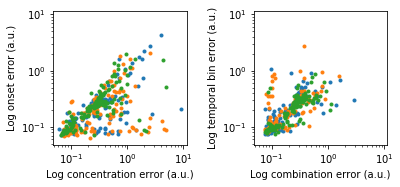

In [21]:
fig = plt.figure()
gs = GridSpec(1, 1)
ea1, ea2 = plot_two_errors(fig, gs[0], all_scores_conc, all_scores_onset, all_scores_cao, all_scores_full, orientation='h')
ea1.set_xlabel('Log concentration error (a.u.)')
ea1.set_ylabel('Log onset error (a.u.)')
ea2.set_xlabel('Log combination error (a.u.)')
ea2.set_ylabel('Log temporal bin error (a.u.)')

In [48]:
print(np.mean(all_scores_cao), np.mean(all_scores_full))
print(ttest_ind(np.array(all_scores_conc).flatten(), np.array(all_scores_onset).flatten()))

0.2506550058990576 0.23591775264511575
Ttest_indResult(statistic=4.308586288527314, pvalue=1.8535596177585816e-05)


In [15]:
def plot_pred_odour(fig, gs, true_vals, pred_vals, chosen_indexes, legend_ax_index=2):

    subgs = gs.subgridspec(ncols=len(chosen_indexes), nrows=1)
    axs = []
    for ax_i, index in enumerate(chosen_indexes):
        if ax_i != 0:
            
            ax = fig.add_subplot(subgs[ax_i], sharey=axs[-1])
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax = fig.add_subplot(subgs[ax_i])
        ax.scatter(range(32), true_vals[index], label='True')
        ax.scatter(range(32), pred_vals[index], label='Prediction')
        axs.append(ax)
        ax.set_xticks(range(32))
        ax.set_xticklabels(glyphs, fontsize=8, rotation=90)
        if ax_i == legend_ax_index:
            ax.legend()
    
    return axs

def pred_other_odour(model1, model2, model3, unit_usrt, ui, pred_trial = -1, ratio_schema = 'pred_trial', include_t=False):
    full_array = em.trial_arrays['diff_array']
    if ratio_schema == 'pred_trial':
        ratio_w1 = model1.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
        ratio_w2 = model2.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
    elif ratio_schema == 'mean':
        ratio_w1 = np.mean(model1.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
        ratio_w2 = np.mean(model2.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
    elif ratio_schema == 'max':
        if model1.true_resp[-1] > model2.true_resp[-1]:
            ratio_w1 = 1
            ratio_w2 = 0
        else:
            ratio_w1 = 0
            ratio_w2 = 1
    if not include_t:
        pred_ws = model1.opt_out.x[:-1]*ratio_w1 + model2.opt_out.x[:-1]*ratio_w2
        avg_thresh = (model1.opt_out.x[-1] + model2.opt_out.x[-1])/2
        pred_out = pred_ws @ full_array[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]) - avg_thresh)/pred_out
        pred_ws = scale*pred_ws
        pred_ws = list(pred_ws) + [avg_thresh]
    else:
        pred_ws = model1.opt_out.x*ratio_w1 + model2.opt_out.x*ratio_w2
        full_array_1 = np.append(full_array, np.ones((32, 1)), axis=1)
        pred_out = pred_ws @ full_array_1[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]))/pred_out
        pred_ws = scale*pred_ws
    model_test = em.ExponentialCustomTrialArray(unit_usrt, ui, full_array)
    model_test.fit(W=pred_ws)
    return model_test

In [21]:
pred_scores1 = []
pred_scores2 = []
pred_scores3 = []

pred_models1 = []
pred_models2 = []
pred_models3 = []
for ui in tqdm(good_indexes, position=0, leave=False):
    model_test = pred_other_odour(full_models2[ui], full_models3[ui], full_models1[ui], unit_usrt1, ui, include_t=True)
    pred_scores1.append(model_test.fit_score)
    pred_models1.append(model_test)
    model_test = pred_other_odour(full_models1[ui], full_models3[ui], full_models2[ui], unit_usrt2, ui, include_t=True)
    pred_scores2.append(model_test.fit_score)
    pred_models2.append(model_test)
    model_test = pred_other_odour(full_models2[ui], full_models1[ui], full_models3[ui], unit_usrt3, ui, include_t=True)
    pred_scores3.append(model_test.fit_score)
    pred_models3.append(model_test)
    

pred_models_pred1 = [i.pred_resp for i in pred_models1]
pred_models_pred2 = [i.pred_resp for i in pred_models2]
pred_models_pred3 = [i.pred_resp for i in pred_models3]

pred_models_true1 = [i.true_resp for i in pred_models1]
pred_models_true2 = [i.true_resp for i in pred_models2]
pred_models_true3 = [i.true_resp for i in pred_models3]

all_pred_models_pred = np.concatenate([pred_models_pred1, pred_models_pred2, pred_models_pred3])
all_pred_models_true = np.concatenate([pred_models_true1, pred_models_true2, pred_models_true3])

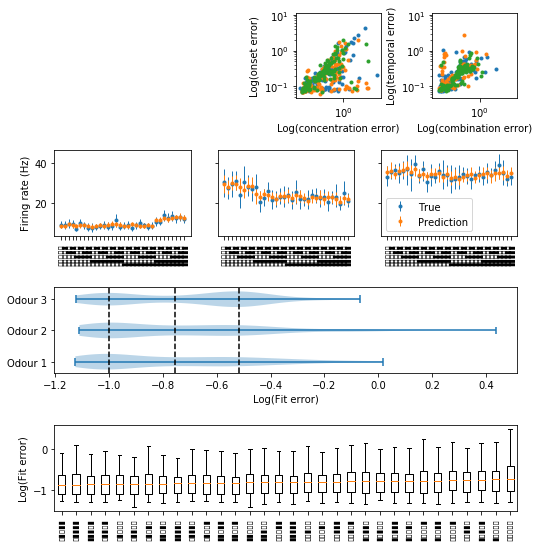

In [56]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(5, 4, hspace=0.6)
ea1, ea2 = plot_two_errors(fig, gs[0, 2:], all_scores_conc, all_scores_onset, all_scores_cao, all_scores_full, orientation='h', wspace=0.6)
ea1.set_xlabel('Log(concentration error)')
ea1.set_ylabel('Log(onset error)')
ea2.set_xlabel('Log(combination error)')
ea2.set_ylabel('Log(temporal error)')
diagram_ax = fig.add_subplot(gs[0, :-2], frameon=False)
diagram_ax.set_xticks([])
diagram_ax.set_yticks([])
plot_axes = plot_fits(fig, gs[1, :], all_test_true, all_test_preds, fit_indexes[1:-1])
dist_ax = fig.add_subplot(gs[2, :])
plot_error_distributions(dist_ax, combined_scores, yticklabels=['Odour 1', 'Odour 2', 'Odour 3'], axvlines=fit_index_values[1:-1])
trial_error_ax = fig.add_subplot(gs[3, :])
plot_trial_scores(trial_error_ax, combined_trial_scores)
#other_odour_pred_ax = fig.add_subplot(gs[5, :])
#plot_error_distributions(other_odour_pred_ax, [pred_scores1, pred_scores2, pred_scores3])
#pred_odour_ax = fig.add_subplot(gs[4, :])
#plot_pred_odour(fig, gs[4, :], all_pred_models_true, all_pred_models_pred, fit_indexes_pred_odour[1:-1])
# heatmap_ax = fig.add_subplot(gs[1, :])
# vmax = np.max(np.abs(firing_difference1))
# link = linkage(np.array(firing_difference1), method='complete', optimal_ordering=True)
# dend = dendrogram(link, no_plot=True)
# im = heatmap_ax.imshow(np.array(firing_difference1)[dend['leaves']].T, cmap='bwr', vmax=vmax, vmin=-vmax)
# divider = make_axes_locatable(heatmap_ax)
# cax = divider.append_axes("right", size='2%', pad=0.05)
# plt.colorbar(im, cax=cax)
#plt.colorbar()

In [11]:
## pred odour further work
full_responding_units = []
for i in good_indexes:
    model1 = full_models1[i]
    model2 = full_models2[i]
    model3 = full_models3[i]
    
    odour1_resp_diff = abs(model1.true_resp[0] - model1.true_resp[-1])
    odour2_resp_diff = abs(model2.true_resp[0] - model2.true_resp[-1])
    odour3_resp_diff = abs(model3.true_resp[0] - model3.true_resp[-1])
    
    odour1_var = np.sqrt(model1.unit_sr_var[0])
    odour2_var = np.sqrt(model2.unit_sr_var[0])
    odour3_var = np.sqrt(model3.unit_sr_var[0])
    if i == 41:
        print(odour1_resp_diff, odour1_var)
    if odour1_resp_diff > odour1_var and odour2_resp_diff > odour2_var and odour3_resp_diff > odour3_var:
        full_responding_units.append(i)

16.26666666666667 4.935134806219133


In [12]:
print(full_responding_units)

[23, 26, 36, 38, 40, 41, 58, 61, 65, 70, 86, 88, 89, 93, 94, 95, 98, 99, 101, 102, 106, 108, 109, 110, 111, 113, 114, 117, 118, 119, 120, 124, 127, 129, 130, 132, 133, 134, 135, 136, 138, 140, 141, 143]


In [13]:
def pred_and_plot_other_odour(fig, gs, model1, model2, model3, unit_usrt, ui):
    pred_model = pred_other_odour(model1, model2, model3, unit_usrt, ui)
    sub_gs = gs.subgridspec(1, 3)
    ax1 = fig.add_subplot(sub_gs[0])
    ax2 = fig.add_subplot(sub_gs[1])
    ax3 = fig.add_subpl
    
    ax1.plot(model1.true_resp)
    ax1.plot()

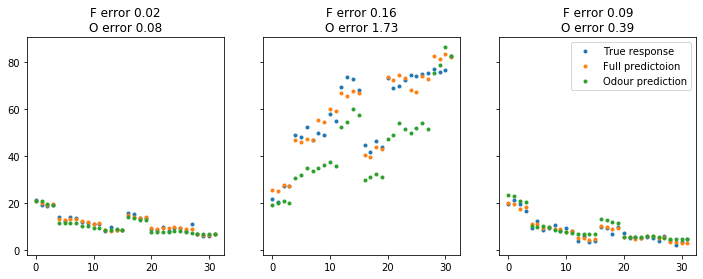

In [16]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ui=38
pred_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
pred_model2 = pred_other_odour(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui)
pred_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
full_models1[ui].fit()
full_models2[ui].fit()
full_models3[ui].fit()

ax[0].plot(pred_model1.true_resp, '.')
ax[0].plot(full_models1[ui].pred_resp, '.')
ax[0].plot(pred_model1.pred_resp, '.')
ax[0].set_title(f'F error {full_models1[ui].fit_score:0.2f}\nO error {pred_model1.fit_score:0.2f}')

ax[1].plot(pred_model2.true_resp, '.')
ax[1].plot(full_models2[ui].pred_resp, '.')
ax[1].plot(pred_model2.pred_resp, '.')
ax[1].set_title(f'F error {full_models2[ui].fit_score:0.2f}\nO error {pred_model2.fit_score:0.2f}')


ax[2].plot(pred_model3.true_resp, '.', label='True response')
ax[2].plot(full_models3[ui].pred_resp, '.',label='Full predictoion')
ax[2].plot(pred_model3.pred_resp, '.',label='Odour prediction')
ax[2].set_title(f'F error {full_models3[ui].fit_score:0.2f}\nO error {pred_model3.fit_score:0.2f}')

ax[2].legend()



In [17]:
scores_pred1 = []
scores_pred2 = []
scores_pred3 = []

scores_full1 = []
scores_full2 = []
scores_full3 = []


for ui in full_responding_units:
    pred_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
    pred_model2 = pred_other_odour(full_models3[ui], full_models2[ui], full_models2[ui], unit_usrt2, ui)
    pred_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
    scores_pred1.append(pred_model1.fit_score)
    scores_pred2.append(pred_model2.fit_score)
    scores_pred3.append(pred_model3.fit_score)
    full_models1[ui].fit()
    full_models2[ui].fit()
    full_models3[ui].fit()
    scores_full1.append(full_models1[ui].fit_score)
    scores_full2.append(full_models2[ui].fit_score)
    scores_full3.append(full_models3[ui].fit_score)

Text(0, 0.5, 'Log(Pred from other odour fit score)')

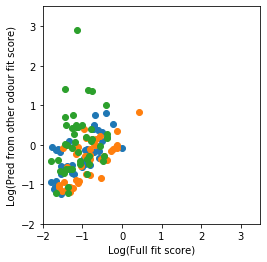

In [18]:
fig = plt.figure()
fig.add_subplot(111, aspect='equal')
plt.scatter(np.log10(scores_full1), np.log10(scores_pred1))
plt.scatter(np.log10(scores_full2), np.log10(scores_pred2))
plt.scatter(np.log10(scores_full3), np.log10(scores_pred3))
plt.xlim(-2, 3.5)
plt.ylim(-2, 3.5)
plt.xlabel('Log(Full fit score)')
plt.ylabel('Log(Pred from other odour fit score)')
#plt.plot(range(-5, 5), range(-5, 5) )

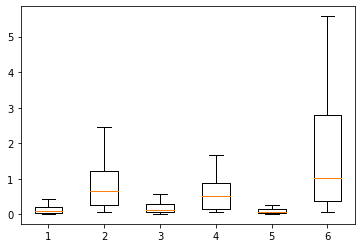

In [19]:
plt.boxplot([scores_full1, scores_pred1, scores_full2, scores_pred2, scores_full3, scores_pred3], showfliers=False);

In [29]:
print(scores_full1)
print(scores_pred1)

[0.017124487431220053, 0.021529209709697184, 0.11026729483324746, 0.0195999197674677, 0.05517348174545862, 0.02644949451386221, 0.1139249374893871, 0.039934952708158084, 0.12738549504718913, 0.055677215066663746, 0.023575855233334365, 0.11794144511736171, 0.14595193293699316, 0.09959868259248755, 0.06022051954196013, 0.17924008004011052, 0.031043853859643623, 0.028334440712879803, 0.035081476595411894, 0.021253331369646838, 0.24025375687842135, 0.02871557074772166, 0.018897171454231382, 0.016177528204861145, 0.02324412435296903, 0.04607696172410378, 0.9729331982371447, 0.02819919491699712, 0.19614226345593327, 0.42635895851922756, 0.2575059061988074, 0.1548165569820033, 0.3040134723746282, 0.30507830584182927, 0.18626386488662192, 0.2020102888846828, 0.26211366465669134, 0.19007433065614332, 0.19308836018597228, 0.23393558040470774, 0.0589881838479343, 0.39350750978001325, 0.6075650282222278, 0.12932480800277787]
[0.8957530383755812, 0.7225596105809546, 0.47017913668669475, 0.083110782

In [20]:
ranked_fits1 = np.argsort(scores_pred1)
ranked_fits2 = np.argsort(scores_pred2)
ranked_fits3 = np.argsort(scores_pred3)
ranked_fits_ui1 = np.array(full_responding_units)[ranked_fits1]
ranked_fits_ui2 = np.array(full_responding_units)[ranked_fits2]
ranked_fits_ui3 = np.array(full_responding_units)[ranked_fits3]

In [21]:
def plot_three_pred_model(ui):
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
    pred_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
    pred_model2 = pred_other_odour(full_models3[ui], full_models1[ui], full_models2[ui], unit_usrt2, ui)
    pred_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
    full_models1[ui].fit()
    full_models2[ui].fit()
    full_models3[ui].fit()

    ax[0].plot(pred_model1.true_resp, '.')
    ax[0].plot(full_models1[ui].pred_resp, '.')
    ax[0].plot(pred_model1.pred_resp, '.')
    ax[0].set_title(f'F error {full_models1[ui].fit_score:0.2f}\nO error {pred_model1.fit_score:0.2f}')

    ax[1].plot(pred_model2.true_resp, '.')
    ax[1].plot(full_models2[ui].pred_resp, '.')
    ax[1].plot(pred_model2.pred_resp, '.')
    ax[1].set_title(f'F error {full_models2[ui].fit_score:0.2f}\nO error {pred_model2.fit_score:0.2f}')


    ax[2].plot(pred_model3.true_resp, '.', label='True response')
    ax[2].plot(full_models3[ui].pred_resp, '.',label='Full predictoion')
    ax[2].plot(pred_model3.pred_resp, '.',label='Odour prediction')
    ax[2].set_title(f'F error {full_models3[ui].fit_score:0.2f}\nO error {pred_model3.fit_score:0.2f}')

    ax[2].legend()


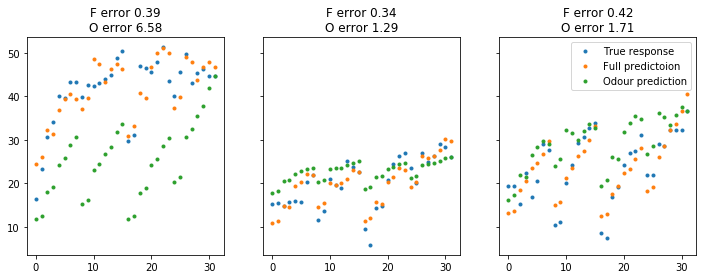

In [22]:
plot_three_pred_model(ranked_fits_ui1[-1])

In [24]:
print(ranked_fits1[-1])

41
